In [1]:
# Install PyTorch Geometric
import torch
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 26.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Dataset: PROTEINS(1113)
-------------------
Number of graphs: 1113
Number of nodes: 51
Number of features: 3
Number of classes: 2


Done!


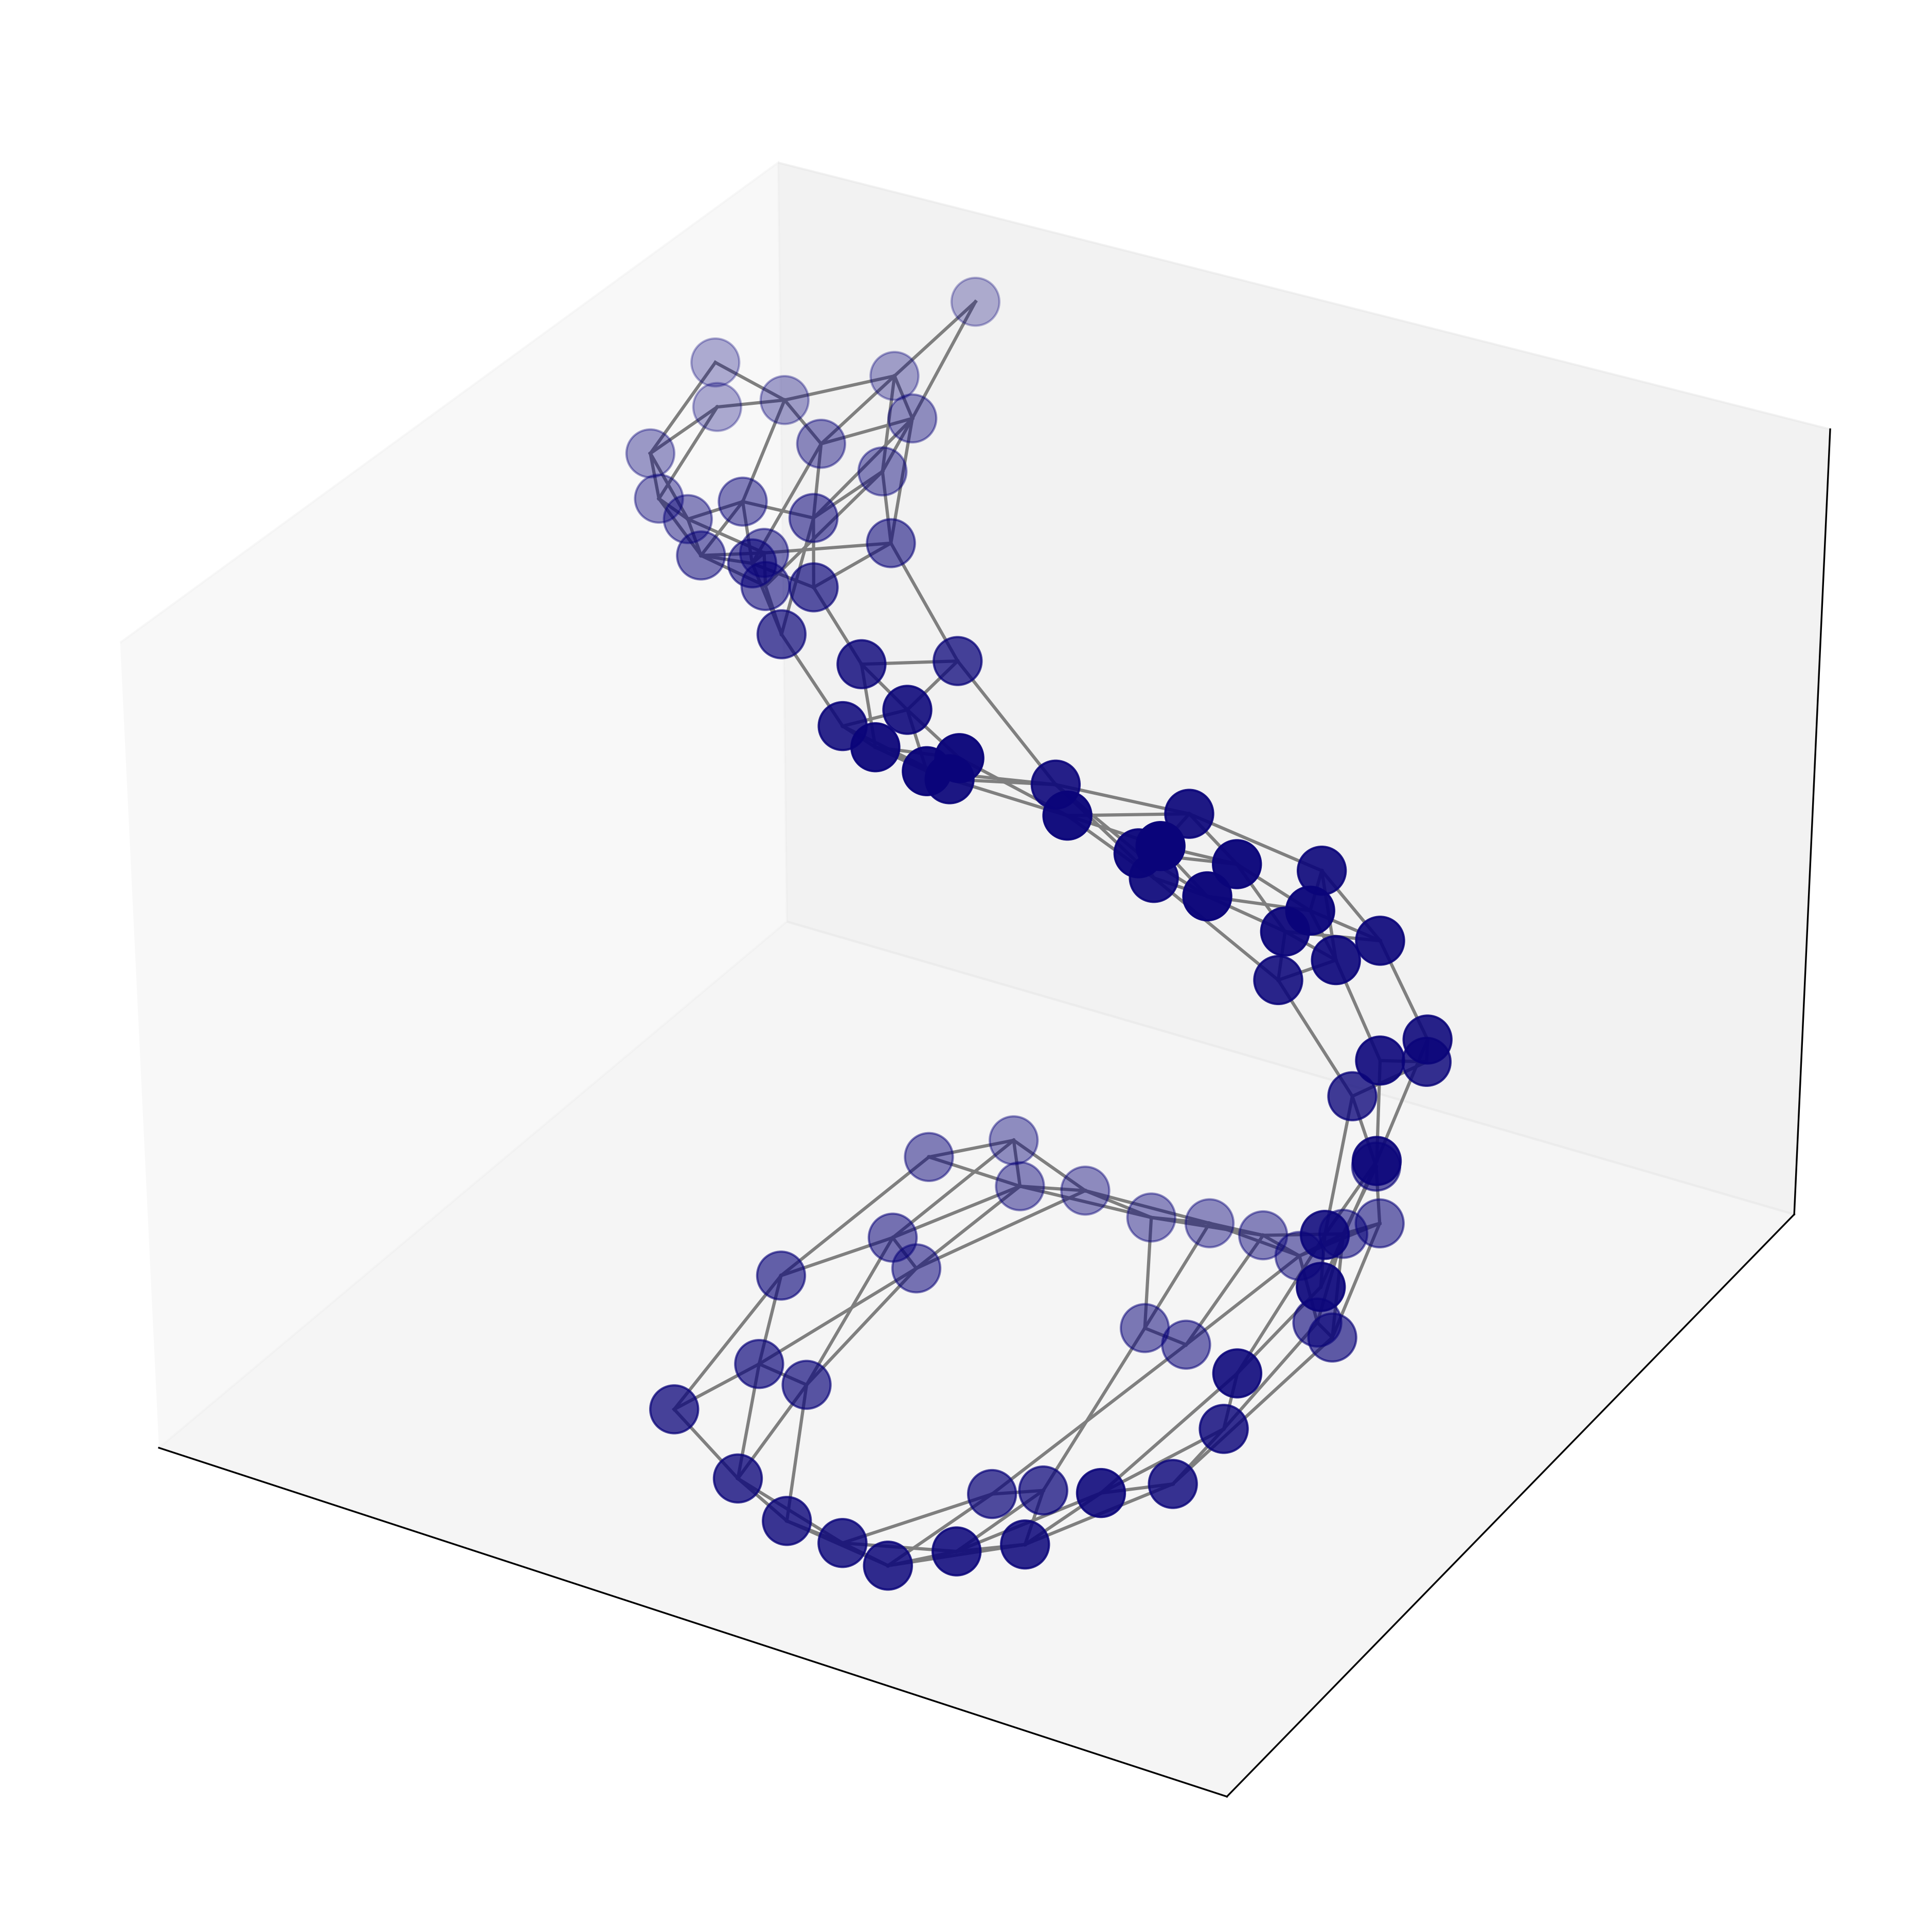

In [3]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[2], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
  dim.set_ticks([])

# Plot the nodes - alpha is scaled by 'depth' automatically
ax.scatter(*node_xyz.T, s=500, c='#0A047A')

# Plot the edges
for vizedge in edge_xyz:
  ax.plot(*vizedge.T, color='tab:gray')

# fig.tight_layout()
plt.show()

In [4]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set  = {len(val_dataset)} graphs')
print(f'Test set     = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
  print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
  print(f' - Subgraph {i}: {subgraph}')

print('\nTest loader:')
for i, subgraph in enumerate(test_loader):
  print(f' - Subgraph {i}: {subgraph}')



Training set   = 890 graphs
Validation set  = 111 graphs
Test set     = 112 graphs

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 12084], x=[3110, 3], y=[64], batch=[3110], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 9232], x=[2498, 3], y=[64], batch=[2498], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 9240], x=[2444, 3], y=[64], batch=[2444], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 9316], x=[2395, 3], y=[64], batch=[2395], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 8480], x=[2317, 3], y=[64], batch=[2317], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 10408], x=[2842, 3], y=[64], batch=[2842], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 7052], x=[1955, 3], y=[64], batch=[1955], ptr=[65])
 - Subgraph 7: DataBatch(edge_index=[2, 8044], x=[2121, 3], y=[64], batch=[2121], ptr=[65])
 - Subgraph 8: DataBatch(edge_index=[2, 7850], x=[2122, 3], y=[64], batch=[2122], ptr=[65])
 - Subgraph 9: DataBatch(edge_index=[2, 10840], x=[2975, 3], y=[64], bat

In [6]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool

class GCN(torch.nn.Module):
  '''GCN'''
  def __init__(self, dim_h):
    super(GCN, self).__init__()
    self.conv1 = GCNConv(dataset.num_node_features, dim_h)
    self.conv2 = GCNConv(dim_h, dim_h)
    self.conv3 = GCNConv(dim_h, dim_h)
    self.lin = Linear(dim_h, dataset.num_classes)

  def forward(self, x, edge_index, batch):
    # Node embeddings
    h = self.conv1(x, edge_index)
    h = h.relu()
    h = self.conv2(h, edge_index)
    h = h.relu()
    h = self.conv3(h, edge_index)

    # Graph-level readout
    hG = global_mean_pool(h, batch)

    # Classifier
    h = F.dropout(hG, p=0.5, training=self.training)
    h = self.lin(h)

    return hG, F.log_softmax(h, dim=1)

class GIN(torch.nn.Module):
  '''GIN'''
  def __init__(self, dim_h):
    super(GIN, self).__init__()
    self.conv1 = GINConv(
          Sequential(Linear(dataset.num_node_features, dim_h),
                BatchNorm1d(dim_h), ReLU(),
                Linear(dim_h, dim_h), ReLU())
          )
    self.conv2 = GINConv(
          Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                Linear(dim_h, dim_h), ReLU())
          )
    self.conv3 = GINConv(
          Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                Linear(dim_h, dim_h), ReLU())
          )
    self.lin1 = Linear(dim_h*3, dim_h*3)
    self.lin2 = Linear(dim_h*3, dataset.num_classes)

  def forward(self, x, edge_index, batch):
    # Node embeddings
    h1 = self.conv1(x, edge_index)
    h2 = self.conv2(h1, edge_index)
    h3 = self.conv3(h2, edge_index)

    # Graph-level readout
    h1 = global_add_pool(h1, batch)
    h2 = global_add_pool(h2, batch)
    h3 = global_add_pool(h3, batch)

    # Concatenate graph embeddings
    h = torch.cat((h1, h2, h3), dim=1)

    # Classifier
    h = self.lin1(h)
    h = h.relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.lin2(h)

    return h, F.log_softmax(h, dim=1)

gcn = GCN(dim_h=32)
gin = GIN(dim_h=32)

print(gcn)
print(gin)

GCN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)
GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (lin1): 

In [8]:
@torch.no_grad()
def test(model, loader):
  criterion = torch.nn.CrossEntropyLoss()
  model.eval()
  loss = 0
  acc = 0

  for data in loader:
    _, out = model(data.x, data.edge_index, data.batch)
    loss += criterion(out, data.y) / len(loader)
    acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

  return loss, acc

def accuracy(pred_y, y):
  '''Calculate accuracy.'''
  return ((pred_y == y).sum() / len(y)).item()

def train(model, loader):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),
                  lr=0.01,
                  weight_decay=0.01)
  epochs = 100

  model.train()
  for epoch in range(epochs+1):
    total_loss = 0
    acc = 0
    val_loss = 0
    val_acc = 0

    # Train on batches
    for data in loader:
      optimizer.zero_grad()
      _, out = model(data.x, data.edge_index, data.batch)
      loss = criterion(out, data.y)
      total_loss += loss / len(loader)
      acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
      loss.backward()
      optimizer.step()

      # Validation
      val_loss, val_acc = test(model, val_loader)

    # Print metrics every 10 epochs
    if(epoch % 10 == 0):
      print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
        f'| Train Acc: {acc*100:>5.2f}% '
        f'| Val Loss: {val_loss:.2f} '
        f'| Val Acc: {val_acc*100:.2f}%')

  test_loss, test_acc = test(model, test_loader)
  print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

  return model

gcn = train(gcn, train_loader)
gin = train(gin, train_loader)

Epoch   0 | Train Loss: 0.68 | Train Acc: 59.17% | Val Loss: 0.66 | Val Acc: 63.73%
Epoch  10 | Train Loss: 0.68 | Train Acc: 59.24% | Val Loss: 0.66 | Val Acc: 63.16%
Epoch  20 | Train Loss: 0.68 | Train Acc: 59.22% | Val Loss: 0.66 | Val Acc: 63.45%
Epoch  30 | Train Loss: 0.68 | Train Acc: 59.17% | Val Loss: 0.66 | Val Acc: 64.01%
Epoch  40 | Train Loss: 0.68 | Train Acc: 59.22% | Val Loss: 0.67 | Val Acc: 62.32%
Epoch  50 | Train Loss: 0.68 | Train Acc: 59.21% | Val Loss: 0.66 | Val Acc: 63.73%
Epoch  60 | Train Loss: 0.68 | Train Acc: 59.21% | Val Loss: 0.67 | Val Acc: 61.75%
Epoch  70 | Train Loss: 0.68 | Train Acc: 59.15% | Val Loss: 0.66 | Val Acc: 62.60%
Epoch  80 | Train Loss: 0.68 | Train Acc: 59.20% | Val Loss: 0.66 | Val Acc: 64.30%
Epoch  90 | Train Loss: 0.68 | Train Acc: 59.27% | Val Loss: 0.66 | Val Acc: 62.60%
Epoch 100 | Train Loss: 0.68 | Train Acc: 59.24% | Val Loss: 0.66 | Val Acc: 62.60%
Test Loss: 0.68 | Test Acc: 58.85%
Epoch   0 | Train Loss: 1.07 | Train Acc:

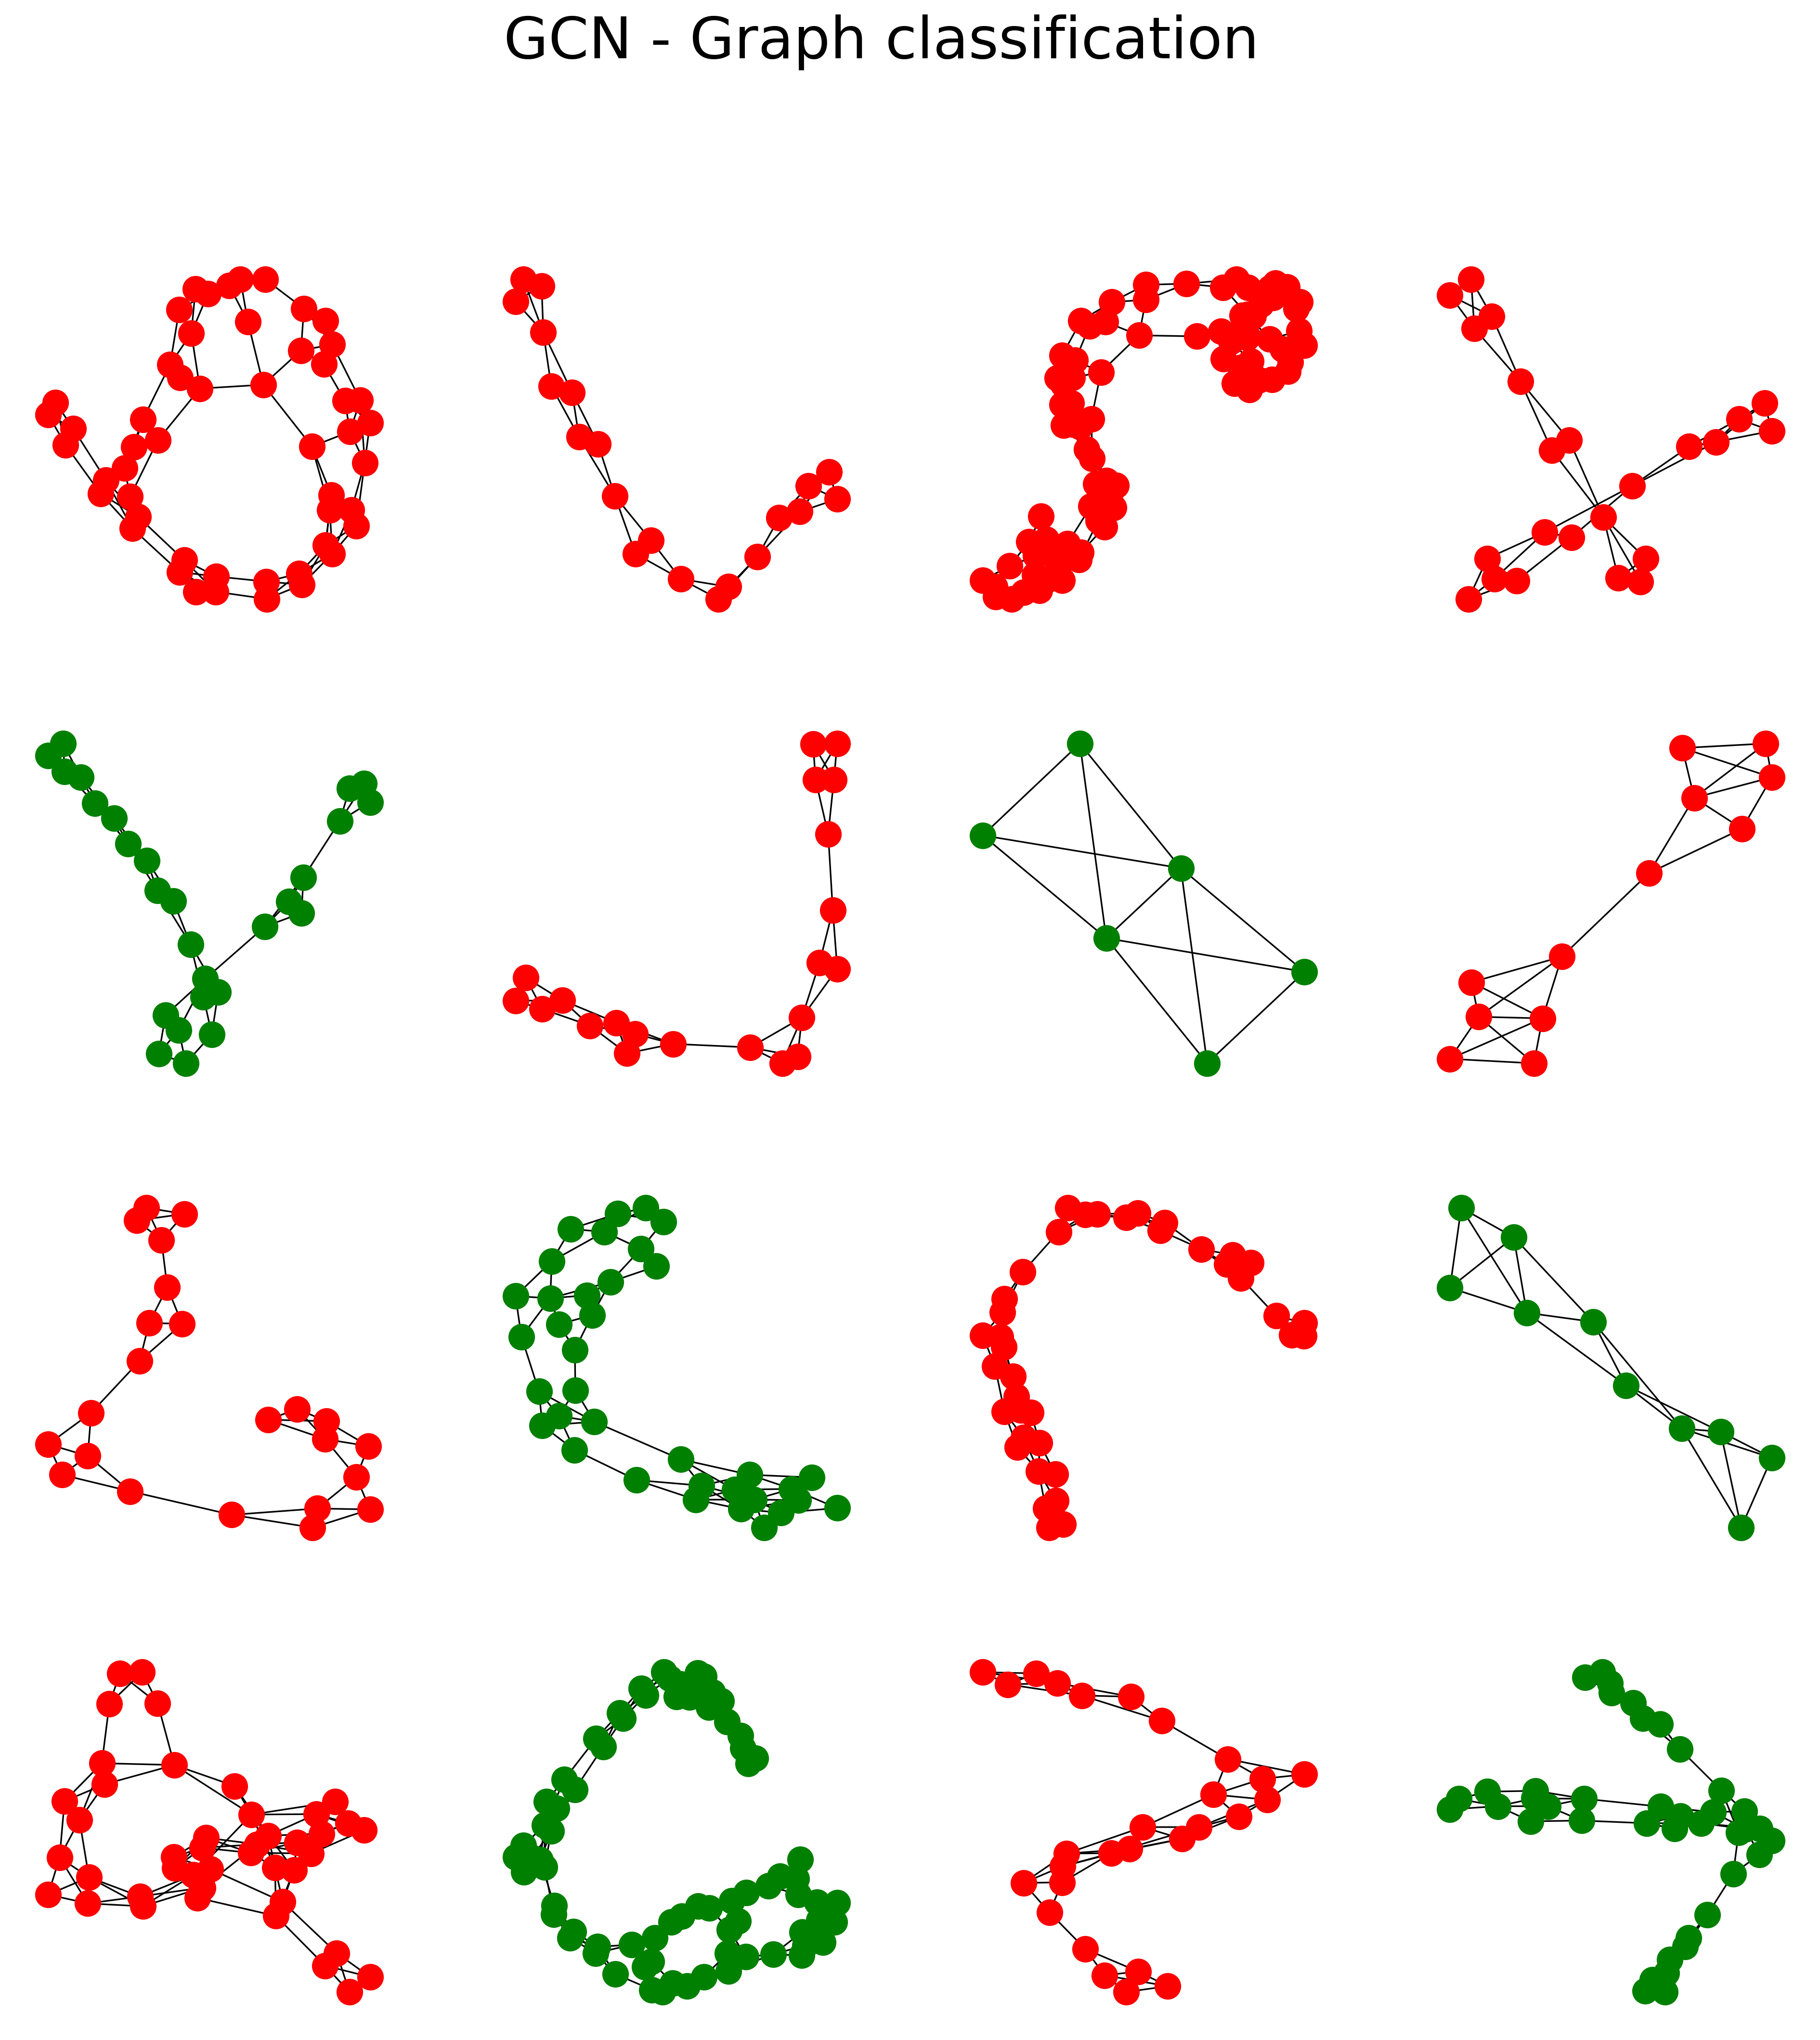

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GCN - Graph classification')

for i, data in enumerate(dataset[1113-16:]):
  # Calculate color (green if correct, red otherwise)
  _, out = gcn(data.x, data.edge_index, data.batch)
  color = 'green' if out.argmax(dim=1) == data.y else 'red'

  # Plot graph
  ix = np.unravel_index(i, ax.shape)
  ax[ix].axis('off')
  G = to_networkx(dataset[i], to_undirected=True)
  nx.draw_networkx(G,
          pos=nx.spring_layout(G, seed=0),
          with_labels=False,
          node_size=150,
          node_color=color,
          width=0.8,
          ax=ax[ix]
          )

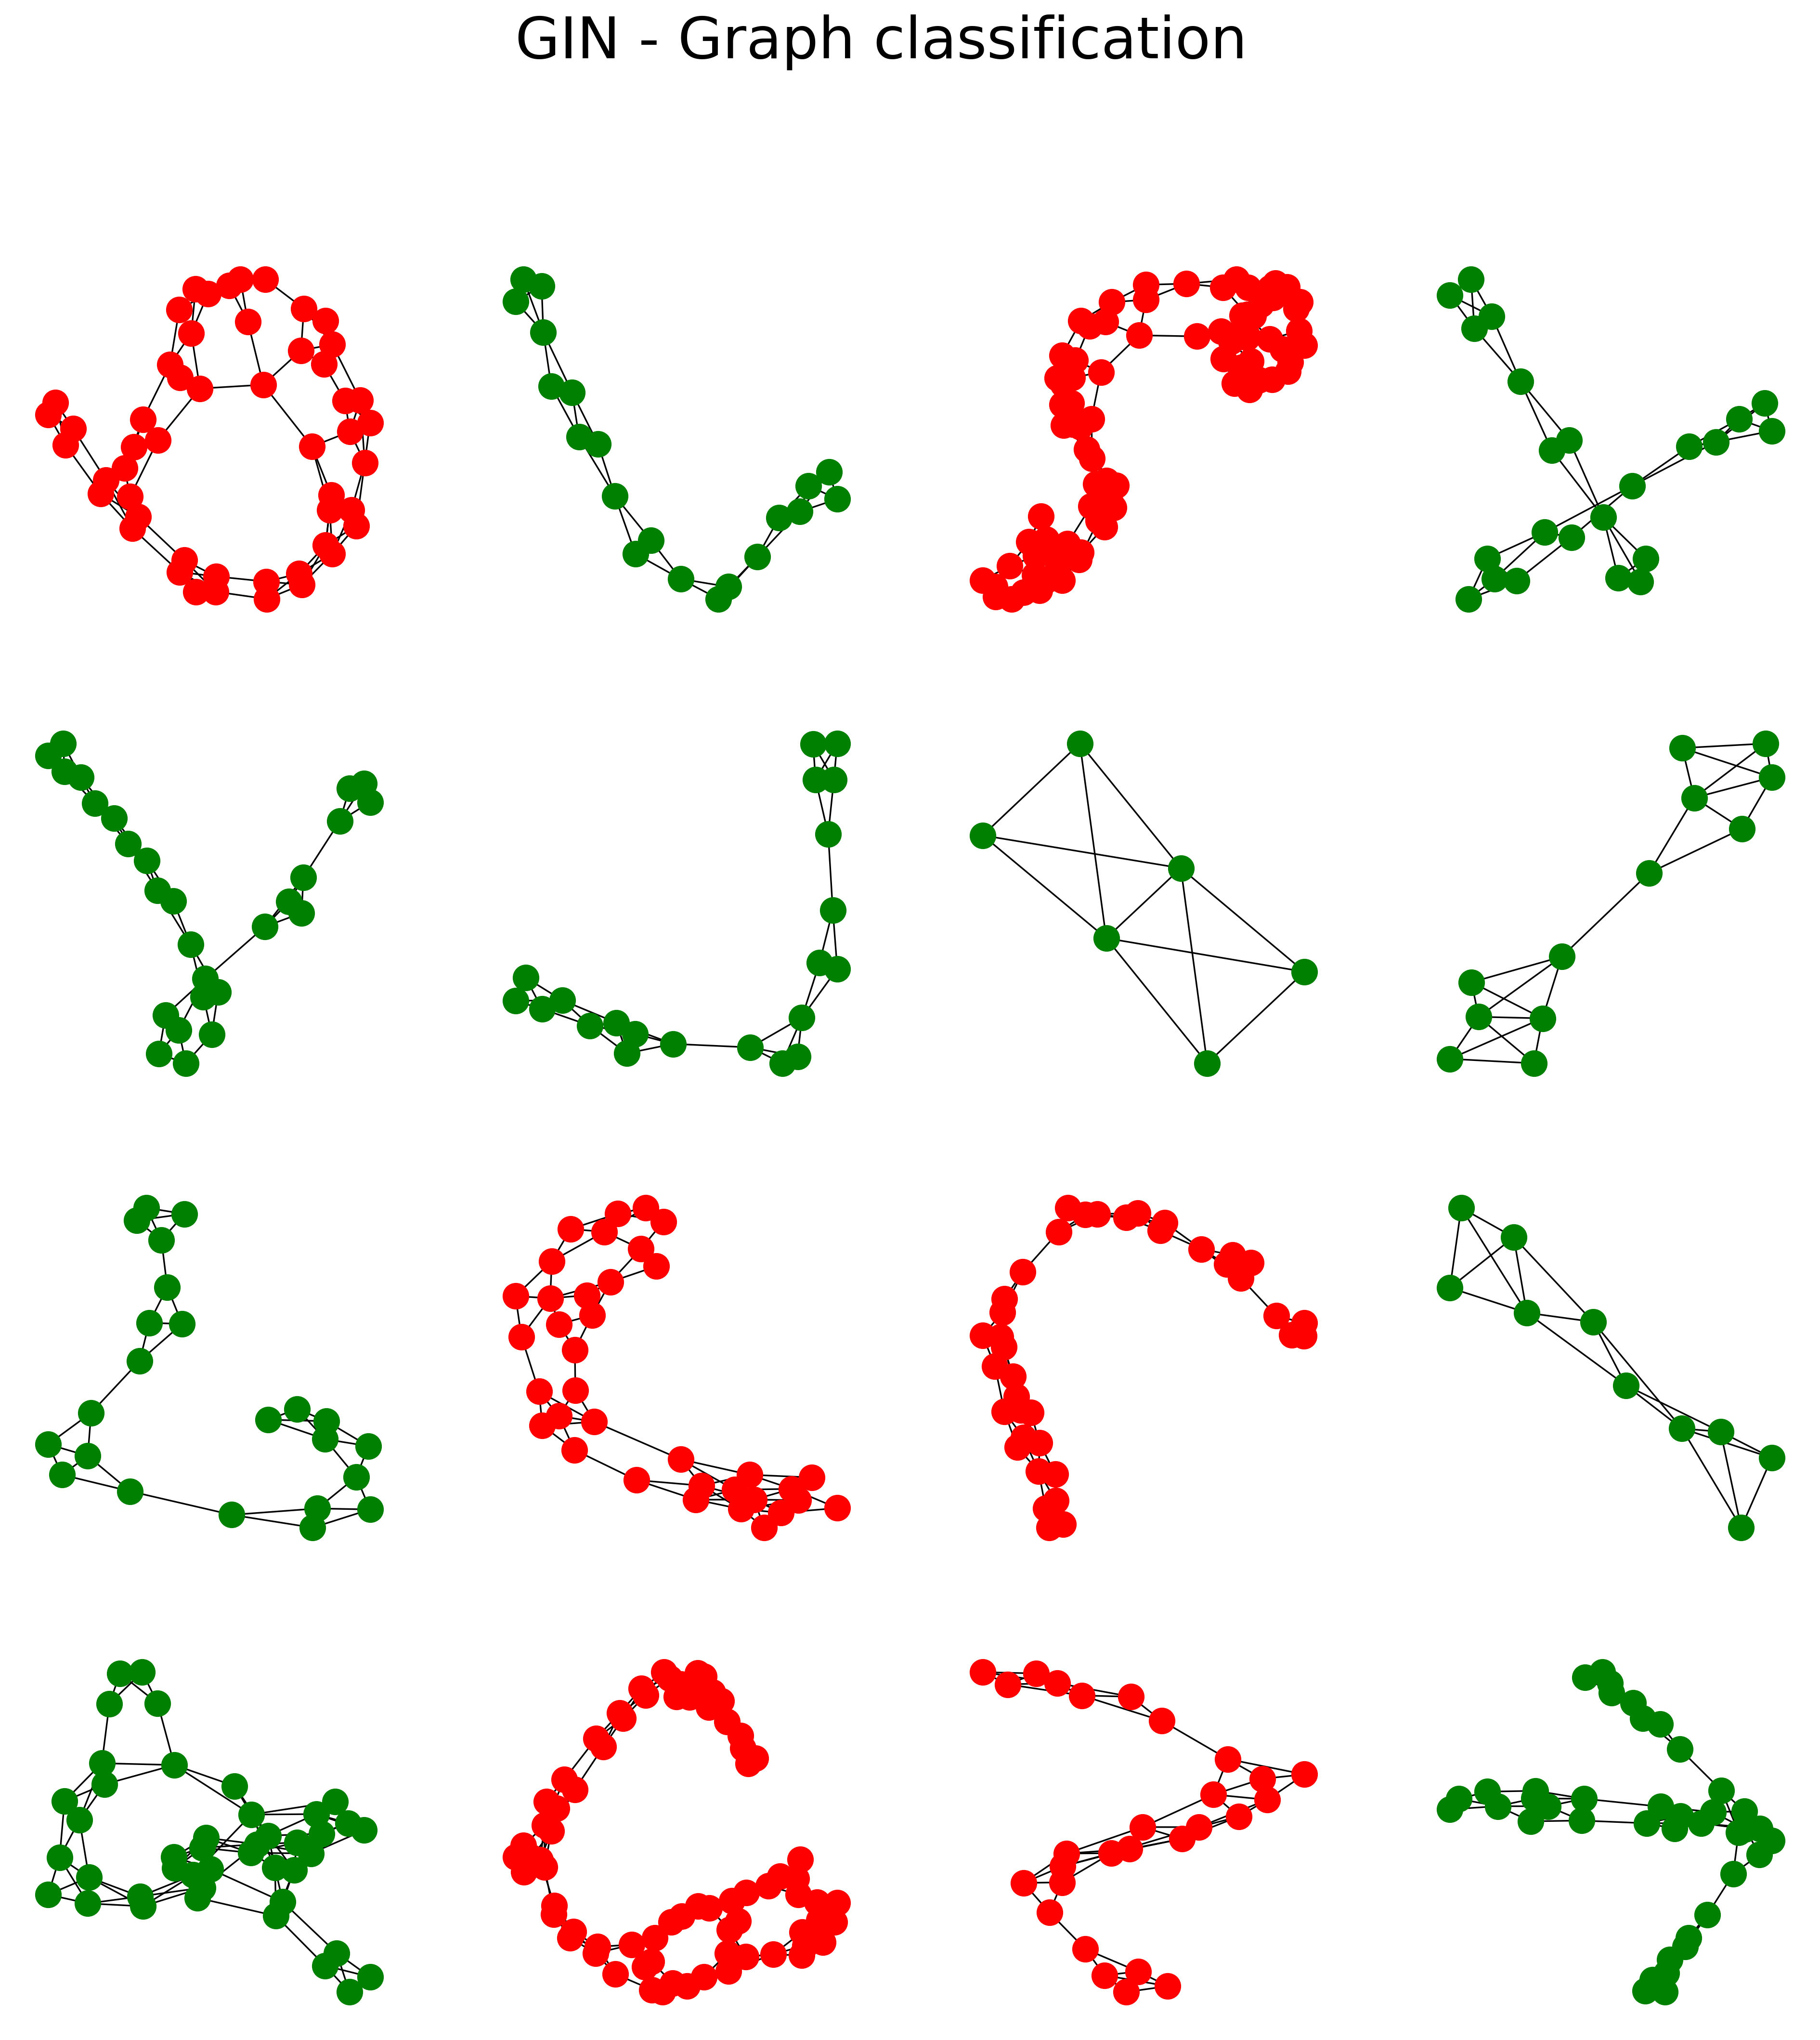

In [10]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[1113-16:]):
  # Calculate color (green if correct, red otherwise)
  _, out = gin(data.x, data.edge_index, data.batch)
  color = 'green' if out.argmax(dim=1) == data.y else 'red'

  # Plot graph
  ix = np.unravel_index(i, ax.shape)
  ax[ix].axis('off')
  G = to_networkx(dataset[i], to_undirected=True)
  nx.draw_networkx(G,
          pos=nx.spring_layout(G, seed=0),
          with_labels=False,
          node_size=150,
          node_color=color,
          width=0.8,
          ax=ax[ix]
          )

In [11]:
gcn.eval()
gin.eval()

acc_gcn = 0
acc_gin = 0
acc = 0

for data in test_loader:
  # Get classifications
  _, out_gcn = gcn(data.x, data.edge_index, data.batch)
  _, out_gin = gin(data.x, data.edge_index, data.batch)
  out = (out_gcn + out_gin)/2

  # Calculate accuracy scores
  acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
  acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
  acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:   {acc_gcn*100:.2f}%')
print(f'GIN accuracy:   {acc_gin*100:.2f}%')
print(f'GCN+GIN accuracy: {acc*100:.2f}%')

GCN accuracy:   58.85%
GIN accuracy:   64.32%
GCN+GIN accuracy: 72.40%
